Business often spends money to acquire new customers. What if customer is not longer have business with business. It is importance to tackle problem of churn out which hurt business

In [2]:
from __future__ import division
from datetime import datetime, timedelta,date
import seaborn as sns
import pandas as pd

import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.cluster import KMeans
import xgboost as xgb

In [3]:
df= pd.read_csv('./Downloads/data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df.Churn.replace({'No':0,'Yes':1}, inplace = True)
df.groupby('gender').Churn.sum()/df.shape[0]

gender
Female    0.133324
Male      0.132046
Name: Churn, dtype: float64

In [7]:
df.tenure.describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

Simply to reorder cluster 

In [8]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


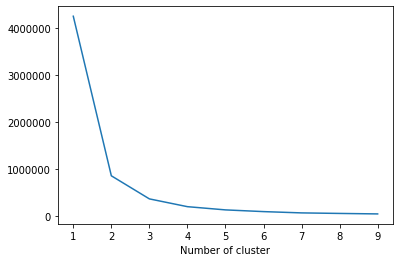

In [9]:
sse={}
df_cluster = df[['tenure']].copy()
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [10]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df[['tenure']])
df['TenureCluster'] = kmeans.predict(df[['tenure']])

df = order_cluster('TenureCluster', 'tenure',df,True)
df.groupby('TenureCluster').tenure.describe()

,count,mean,std,min,25%,50%,75%,max
TenureCluster,,,,,,,,
0,2941.0,7.801428,6.227163,0.0,2.0,6.0,13.0,21.0
1,1929.0,34.792120,8.297679,22.0,27.0,35.0,42.0,49.0
2,2173.0,63.475380,7.172433,50.0,57.0,65.0,70.0,72.0


In [11]:
df['TenureCluster'] = df["TenureCluster"].replace({0:'Low',1:'Mid',2:'High'})

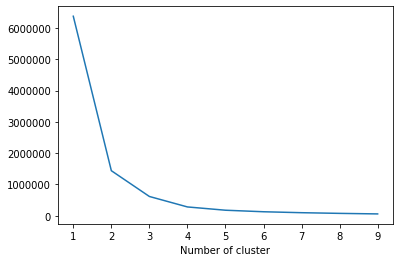

In [12]:
sse={}
df_cluster = df[['MonthlyCharges']].copy()
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [13]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df[['MonthlyCharges']])
df['MonthlyChargeCluster'] = kmeans.predict(df[['MonthlyCharges']])

df = order_cluster('MonthlyChargeCluster', 'MonthlyCharges',df,True)
df.groupby('MonthlyChargeCluster').MonthlyCharges.describe()

,count,mean,std,min,25%,50%,75%,max
MonthlyChargeCluster,,,,,,,,
0,1892.0,23.384619,5.660437,18.25,19.80,20.40,25.0500,42.40
1,2239.0,61.628808,10.441432,42.60,51.80,61.55,70.7000,77.80
2,2912.0,94.054258,10.343944,77.85,85.05,93.90,101.9125,118.75


In [14]:
df['MonthlyChargeCluster'] = df["MonthlyChargeCluster"].replace({0:'Low',1:'Mid',2:'High'})
df[pd.to_numeric(df['TotalCharges'], errors='coerce').isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TenureCluster,MonthlyChargeCluster
92,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,20.25,,0,Low,Low
138,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,25.75,,0,Low,Low
425,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,19.85,,0,Low,Low
488,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,25.35,,0,Low,Low
566,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,20.00,,0,Low,Low
681,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0,Low,Low
1977,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0,Low,Mid
2116,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,No,Two year,No,Credit card (automatic),56.05,,0,Low,Mid
3016,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,No,Two year,No,Mailed check,73.35,,0,Low,Mid
3029,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,...,No,No,Two year,Yes,Bank transfer (automatic),61.90,,0,Low,Mid


In [15]:
len(df[pd.to_numeric(df['TotalCharges'], errors='coerce').isnull()])

11

In [16]:
df.loc[pd.to_numeric(df['TotalCharges'], errors='coerce').isnull(),'TotalCharges'] = np.nan
df = df.dropna()

In [17]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

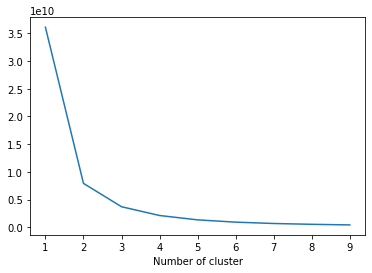

In [19]:
sse={}
df_cluster = df[['TotalCharges']].copy()
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [20]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df[['TotalCharges']])
df['TotalChargeCluster'] = kmeans.predict(df[['TotalCharges']])

df = order_cluster('TotalChargeCluster', 'TotalCharges',df,True)
df.groupby('TotalChargeCluster').TotalCharges.describe()

,count,mean,std,min,25%,50%,75%,max
TotalChargeCluster,,,,,,,,
0,4146.0,681.879112,568.118560,18.80,160.925,533.275,1132.1375,1956.40
1,1616.0,3251.163150,812.918696,1957.10,2531.700,3188.950,3953.8000,4749.15
2,1270.0,6279.699409,1009.064405,4750.95,5449.125,6140.175,7034.5625,8684.80


In [21]:
df['TotalChargeCluster'] = df["TotalChargeCluster"].replace({0:'Low',1:'Mid',2:'High'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customerID            7032 non-null   object 
 1   gender                7032 non-null   object 
 2   SeniorCitizen         7032 non-null   int64  
 3   Partner               7032 non-null   object 
 4   Dependents            7032 non-null   object 
 5   tenure                7032 non-null   int64  
 6   PhoneService          7032 non-null   object 
 7   MultipleLines         7032 non-null   object 
 8   InternetService       7032 non-null   object 
 9   OnlineSecurity        7032 non-null   object 
 10  OnlineBackup          7032 non-null   object 
 11  DeviceProtection      7032 non-null   object 
 12  TechSupport           7032 non-null   object 
 13  StreamingTV           7032 non-null   object 
 14  StreamingMovies       7032 non-null   object 
 15  Contract             

In [22]:

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

dummy_columns = [] #array for multiple value columns

for column in df.columns:
    if df[column].dtype == object and column != 'customerID':
        if df[column].nunique() == 2:
            #apply Label Encoder for binary ones
            df[column] = le.fit_transform(df[column]) 
        else:
            dummy_columns.append(column)

#apply get dummies for selected columns
df = pd.get_dummies(data = df,columns = dummy_columns)

In [23]:
df[['gender','Partner','TenureCluster_High','TenureCluster_Low','TenureCluster_Mid']].head()

,gender,Partner,TenureCluster_High,TenureCluster_Low,TenureCluster_Mid
0,0,1,0,1,0
1,0,0,0,1,0
2,1,0,0,1,0
3,1,0,0,1,0
4,1,1,0,1,0


In [25]:
all_columns = []
for column in df.columns:
    column = column.replace(" ", "_").replace("(", "_").replace(")", "_").replace("-", "_")
    all_columns.append(column)

df.columns = all_columns 

In [26]:
glm_columns = 'gender'

for column in df.columns:
    if column not in ['Churn','customerID','gender']:
        glm_columns = glm_columns + ' + ' + column

In [28]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
 

glm_model = smf.glm(formula='Churn ~ {}'.format(glm_columns), data=df, family=sm.families.Binomial())
res = glm_model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                            GLM   Df Residuals:                     7002
Model Family:                Binomial   Df Model:                           29
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2902.1
Date:                Wed, 29 Apr 2020   Deviance:                       5804.1
Time:                        07:31:45   Pearson chi2:                 7.57e+03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [29]:
np.exp(res.params)

Intercept                                  1.291446
gender                                     0.977403
SeniorCitizen                              1.247651
Partner                                    0.998805
Dependents                                 0.877312
tenure                                     0.940776
PhoneService                               1.257218
PaperlessBilling                           1.414815
MonthlyCharges                             0.966344
TotalCharges                               1.000099
MultipleLines_No                           0.891401
MultipleLines_No_phone_service             1.027225
MultipleLines_Yes                          1.410385
InternetService_DSL                        0.547581
InternetService_Fiber_optic                2.865912
InternetService_No                         0.822934
OnlineSecurity_No                          1.388585
OnlineSecurity_No_internet_service         0.822934
OnlineSecurity_Yes                         1.130157
OnlineBackup

In [30]:
#create feature set and labels
X = df.drop(['Churn','customerID'],axis=1)
y = df.Churn

#train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

In [31]:
#building the model
xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.84
Accuracy of XGB classifier on test set: 0.82


In [32]:
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       268
           1       0.65      0.51      0.57        84

    accuracy                           0.82       352
   macro avg       0.75      0.71      0.73       352
weighted avg       0.81      0.82      0.81       352



In [ ]:
from xgboost import plot_tree

##set up the parameters
fig, ax = plt.subplots(figsize=(100,100))
plot_tree(xgb_model, ax=ax)

In [ ]:
1/(1+np.exp(-0.032))


In [ ]:
from xgboost import plot_importance

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax)

In [ ]:
df_data['proba'] = xgb_model.predict_proba(df_data[X_train.columns])[:,1]

In [ ]:
df_data[['customerID', 'proba']].head()